In [1]:
import pandas as pd

file_path = r"C:\Users\patry\Downloads\archive.zip"

df = pd.read_csv(file_path)

In [2]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
import re
import pandas as pd

def extract_user(tweet):
    match = re.search(r'@(\w+):', tweet)
    return match.group(1) if match else None

def extract_text(tweet):
    # Usuwamy wszystko przed dwukropkiem (w tym samym przedrostek @nazwa_uzytkownika)
    match = re.search(r':\s*(.*)', tweet)
    return match.group(1) if match else tweet

df['user'] = df['tweet'].apply(extract_user)
df['text'] = df['tweet'].apply(extract_text)

df.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,user,text
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,mayasolovely,As a woman you shouldn't complain about cleani...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,mleew17,boy dats cold...tyga dwn bad for cuffin dat ho...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,80sbaby4life,You ever fuck a bitch and she start to cry? Yo...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,C_G_Anderson,@viva_based she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,ShenikaRoberts,The shit you hear about me might be true or it...


In [4]:
from datasets import Dataset, DatasetDict,ClassLabel
from sklearn.model_selection import train_test_split
from collections import defaultdict

df = df.drop(['count', 'Unnamed: 0', 'offensive_language', 'neither', 'tweet', 'hate_speech'], axis=1)
df = df.rename(columns={'class': 'label'})

train_df, test_val_df = train_test_split(df, test_size=0.3, random_state=1)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=1)

hate_dataset = DatasetDict()

splits = ['train', 'test', 'val']
dataframes = [train_df, test_df, val_df]

for split_name, dataframe in zip(splits, dataframes):
    hate_dataset[split_name] = (
        Dataset
        .from_pandas(dataframe)
        .remove_columns('__index_level_0__')
        .shuffle(seed=1)
    )

hate_dataset


C:\Users\patry\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['label', 'user', 'text'],
        num_rows: 17348
    })
    test: Dataset({
        features: ['label', 'user', 'text'],
        num_rows: 3717
    })
    val: Dataset({
        features: ['label', 'user', 'text'],
        num_rows: 3718
    })
})

In [5]:
label_list = ["hate speech", "offensive language", "neither"]

def label2str(batch):
    return {'label_name': label_list[batch['label']]}

hate_dataset = hate_dataset.map(label2str)

Map: 100%|███████████████████████████████████████████████████████████████| 3718/3718 [00:00<00:00, 10699.89 examples/s]


<Axes: ylabel='label_name'>

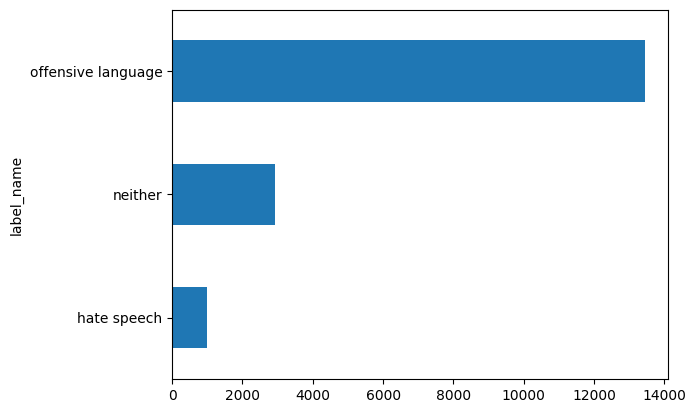

In [6]:
hate_dataset.set_format('pandas')

hate_dataset['train']['label_name'].value_counts(ascending=True).plot.barh()

In [7]:
from transformers import AutoTokenizer

model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

random_text = 'I like eat kebab with mix meat'
random_ids = tokenizer(random_text)
pd.DataFrame([random_text.split(), random_ids.input_ids, random_ids.tokens()])

,0,1,2,3,4,5,6,7,8,9,10
0,I,like,eat,kebab,with,mix,meat,None,None,None,None
1,101,1045,2066,4521,17710,3676,2497,2007,4666,6240,102
2,[CLS],i,like,eat,ke,##ba,##b,with,mix,meat,[SEP]


In [8]:
hate_dataset.reset_format()

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

# Apply the tokenize function to all splits in the dataset
hate_dataset = hate_dataset.map(tokenize, batched=True)

Map: 100%|████████████████████████████████████████████████████████████████| 3718/3718 [00:00<00:00, 9892.60 examples/s]


In [9]:
import torch 
from transformers import AutoModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained(model_name).to(device)

In [10]:
import torch

def extract_last_hidden_state(batch):
    # Move input tensors to the correct device
    input_ids = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

    # Disable gradient calculation for inference
    with torch.no_grad():
        # Forward pass through the model
        outputs = model(**input_ids)
        last_hidden_state = outputs.last_hidden_state

    return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}  # Move the hidden state back to CPU if using GPU

# Ensure the dataset is in the correct format for PyTorch tensors
hate_dataset.set_format('torch')

# Apply the extract_last_hidden_state function to all splits in the dataset
hate_data_hidden = hate_dataset.map(extract_last_hidden_state, batched=True, batch_size=8)


Map: 100%|█████████████████████████████████████████████████████████████████| 3718/3718 [00:16<00:00, 231.54 examples/s]


In [11]:
import numpy as np

hate_data_hidden.reset_format()

X_train = np.array(hate_data_hidden['train']['hidden_state'])
X_val = np.array(hate_data_hidden['val']['hidden_state'])
y_train = np.array(hate_data_hidden['train']['label'])
y_val = np.array(hate_data_hidden['val']['label'])


In [12]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train

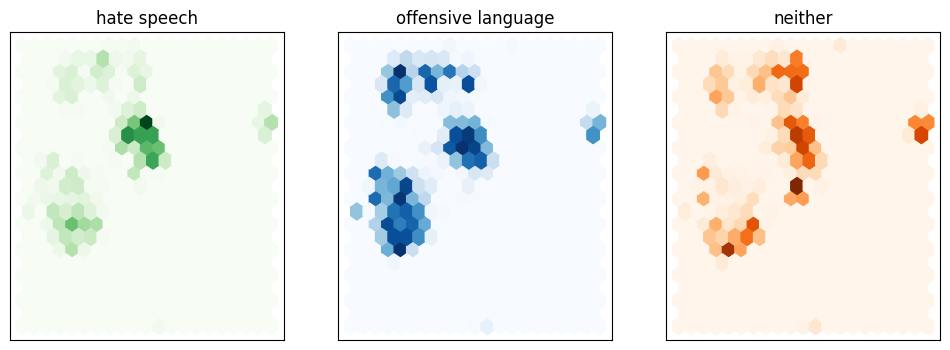

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs = axs.flatten()

cmaps = ['Greens', 'Blues', 'Oranges']

for i, (cmap, label) in enumerate(zip(cmaps, label_list)):
    df_sbp_eb = df_emb.query(f"label == {i}")
    
    axs[i].hexbin(df_sbp_eb['X'], df_sbp_eb['Y'], cmap=cmap, gridsize=20)
    axs[i].set_title(label)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [14]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=3000)

clf.fit(X_train, y_train)

# Print the accuracy of the model on the training data
accuracy = clf.score(X_val, y_val)
print(f"Accuracy on training data: {accuracy}")


Accuracy on training data: 0.8458848843464228


In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cofusion_matrix(y_true, y_pred, labels):
    fig, axes = plt.subplots(figsize=(6, 6))

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    disp.plot(colorbar=False, cmap='Blues', values_format=".2f", ax=axes)

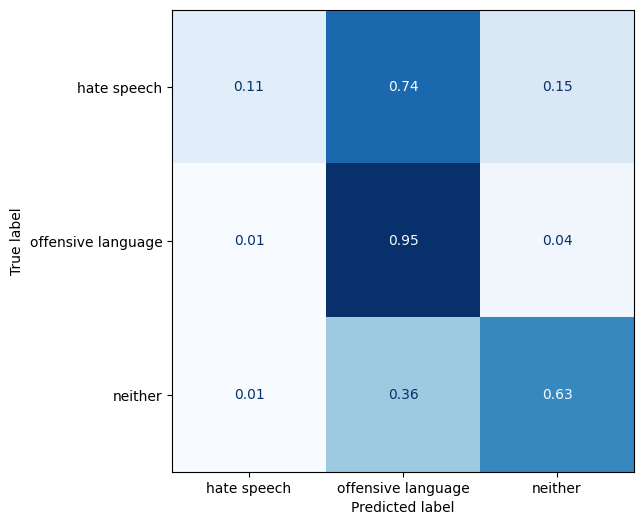

In [16]:
y_pred = clf.predict(X_val)

plot_cofusion_matrix(y_val, y_pred, label_list)

# Fine tune a DitilBERT model

In [17]:
from transformers import AutoModelForSequenceClassification

model = (
    AutoModelForSequenceClassification
    .from_pretrained(model_name, num_labels = len(label_list))
    .to(device)
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

In [19]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(hate_dataset['train']) // batch_size
model_name = f"{model_name} - finetuned - hate"
# Dodajemy liczbę próbek na epokę i dzielimy przez batch_size, aby wyliczyć kroki
save_steps = 100 // batch_size  # Co 100 próbek (steps zależy od batch_size)

training_args = TrainingArguments(
    output_dir='C:/Users/patry/Desktop/step',  # lokalizacja zapisów checkpointów
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy='epoch',
    save_steps=save_steps,  # zapisuj checkpointy co 100 próbek
    save_total_limit=3,  # przechowuj maksymalnie 3 checkpointy
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level='error'
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=hate_dataset['train'],
    eval_dataset=hate_dataset['val'],
    tokenizer=tokenizer
)


C:\Users\patry\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
